**Ph 22 Assignment 4 (Set 5)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#randomizing particle initial values
#positions restrained to circle of size 1
def particlevals(velmag, maxmass):
    
    mass = np.random.rand() * maxmass
    
    ysign = [-1,1][random.randrange(2)]
    vysign = [-1,1][random.randrange(2)]
    
    r = random.uniform(-1,1)
    x = r * random.uniform(-1,1)
    y = np.sqrt(r**2 - x**2) * ysign
    
    vx = 0.1 * random.uniform(-1,1)
    vy = np.sqrt(0.1**2 - vx**2) * vysign
    
    return([x,y,vx,vy,mass])


#making N random particles and putting them in a list
def particlelist(N, velmag, maxmass):
    particlelist = []
    
    for i in range(N):
        pnew = particlevals(velmag,maxmass)
        particlelist.append(pnew)
    
    return(particlelist)

In [3]:
#making quads to put the particles in
class quad:
    def __init__(self, x0, y0, x1, y1):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1
        
        self.midlen = (self.x1-self.x0)/2
        self.x2 = self.x0 + self.midlen
        self.y2 = self.y0 + self.midlen
        
        self.particles = []

    def get_side_length(self):
        return(2*self.midlen)
   
    def get_quadcoords(self):
        return([self.x0,self.y0],[self.x1,self.y1])
    
    def get_subquad(self, x, y):
        if x < self.x2:
            if y < self.y2:
                return(self.child00)
            else:
                return(self.child01)
        else:
            if y < self.y2:
                return(self.child10)
            else:
                return(self.child11)
                
        
    def subdivide(self):
        #divides the quad into its four child quads
        self.child00 = quad(self.x0, self.y0, self.x2, self.y2)
        self.child01 = quad(self.x0, self.y2, self.x2, self.y1)
        self.child10 = quad(self.x2, self.y0, self.x1, self.y2)
        self.child11 = quad(self.x2, self.y2, self.x1, self.y1)
        
    def addparticle(self, plist):
        #print(self.x0, self.x1, self.y0, self.y1, plist[0], plist[1])
        plist = list(plist)
        
        if len(self.particles) == 1:
            self.subdivide()
            p = self.particles[0]
            self.get_subquad(p[0],p[1]).addparticle(p)
        
        self.particles.append(plist)
        
        if len(self.particles) > 1:
            self.get_subquad(plist[0],plist[1]).addparticle(plist)
            
    def get_particles(self):
        return(self.particles)
    
    def get_mass(self):
        mass = 0
        for particle in self.particles:
            mass += particle[4]
        return(mass)
    
#parent quad is square from (-1,-1) to (1,1)
#firstquad = quad(-1, -1, 1, 1)

def fillquad(particlelist):
    quad0 = quad(-256.0, -256.0, 256.0, 256.0)
    for particle in particlelist:
        quad0.addparticle(particle)
    return(quad0)


In [4]:
#physics operations

#takes quadrant 
#and returns center of mass x and y coordinate
def COM(quadrant):
    plist = quadrant.particles
    mtot = quadrant.get_mass()
    N = len(plist)
    
    xave = 0
    yave = 0
    
    for i in range(N):
        mratio = plist[i][4] / mtot
        xave += mratio * plist[i][0]
        yave += mratio * plist[i][1]
    
    return([xave,yave])

def distd(center, pnvals):
    dx = center[0] - pnvals[0]
    dy = center[1] - pnvals[1]
    
    d = np.sqrt(dx**2 + dy**2)
    
    return(d)
    
def ratiotest(parentquad, pnvals):
    plist = parentquad.particles[:]
    converted = list(pnvals)
    
    if converted in plist:
        plist.remove(converted)
    
    l = parentquad.get_side_length()
    center = COM(parentquad)
    d = distd(center, pnvals)
    
    ratio = l/d
    return(ratio, center)


$F = ma$, so we're looking to use
$$\frac{dv}{dt} = \frac{\Delta x}{\mid \Delta x \mid}\frac{m_2}{\mid \Delta x \mid^2 + a^2}$$

In [5]:
def qtforce(parentquad, pnvals, theta, a):
    N = len(parentquad.particles)
    
    if N == 0:
        return(np.zeros(2))
    
    if N == 1:
        plist = parentquad.particles[0] 
        
        if list(pnvals) == list(plist):
            return(np.zeros(2))
        
        r0 = np.array([plist[0],plist[1]]) #if 00 = pnvals, (0,1)
        r1 = np.array([pnvals[0],pnvals[1]]) # (0,0)
        mass = plist[4]
        
        dif = r0 - r1
                
        norm = np.linalg.norm(dif)
          
        grav = mass * dif / (norm*(norm**2 + a**2))
        #print(r0, r1, dif, norm, mass, grav)
        return(grav)
        
    else:
        ld, center = ratiotest(parentquad, pnvals)
        
        if ld <= theta:
            pnxy = np.array([pnvals[0],pnvals[1]])
            com = np.array(center)
            mtot = parentquad.get_mass()
            
            dif = com - pnxy
            norm = np.linalg.norm(dif)
                
            grav = mtot * dif / (norm*(norm**2 + a**2))
            #print(com, pnxy, dif, norm, mtot, grav)
            return(grav)
            
        else:
            grav = np.zeros(2)
            childlist = [parentquad.child00, parentquad.child01, parentquad.child10, parentquad.child11]
            
            for child in childlist:
                grav += qtforce(child, pnvals, theta, a)
                
            return(grav)

In [6]:
#this is for use with the above force function
#not a general fx

def eulerstep(partarray, h, theta, a):
    parentquad = fillquad(partarray)
    newparts =[]
    
    for pvals in partarray: #each particle individually
        oldvals = np.array(pvals)
        
        force = qtforce(parentquad, pvals, theta, a)
        ax = force[0]
        ay = force[1]
        
        step = h * np.array([oldvals[2],oldvals[3],ax,ay,0])
        newvals = oldvals + step
        
        newparts.append(newvals)
        
    return(newparts)
    
    
def stepper(steps, p0array, h, theta, a):
    partevol = []
    partevol.append(p0array)
    current = p0array
    
    for i in range(steps):
        
        sysstep = eulerstep(current, h, theta, a)
        current = sysstep
        partevol.append(sysstep)
    
    return(partevol)

In [7]:
trial1 = particlelist(100, 0.01, 0.001)

trial3 = [[0,0,0,0,1],[0,1,0,0,1]]
trial2 = [[0,0,0,0,1],[0,1,0,0,1],[1,0,0,0,1]]

In [8]:
%%time
steps1 = stepper(100, trial1, 0.1, 0.5, 0.3)

Wall time: 30.8 s


In [9]:
%%time
steps2 = stepper(100, trial1, 0.1, 0.25, 0.3)

Wall time: 35.3 s


In [10]:
%%time
steps3 = stepper(100, trial1, 0.1, 0.75, 0.3)

Wall time: 26.8 s


In [11]:
%%time
steps4 = stepper(100, trial1, 0.1, 0.9, 0.3)

Wall time: 26.9 s


In [12]:
%%time
steps5 = stepper(100, trial1, 0.1, 0.95, 0.3)

Wall time: 25.5 s


In [13]:
%%time
steps6 = stepper(100, trial1, 0.1, 0.1, 0.3)

Wall time: 49.6 s


Theta going from 0.1 to 0.95 just about doubles the computation time.

(-1.0716377751901962,
 0.9650530802058166,
 -1.2717536194268924,
 1.2049050436645676)

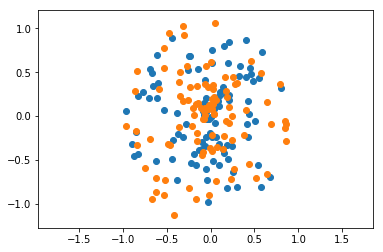

In [14]:
flipstep = np.transpose(steps1[0])
flipstep2 = np.transpose(steps1[-1])
plt.scatter(flipstep[0],flipstep[1])
plt.scatter(flipstep2[0],flipstep2[1])

plt.axis('equal')

(-1.0810231199868348,
 0.9698060294700337,
 -1.277976050347978,
 1.2054234439657292)

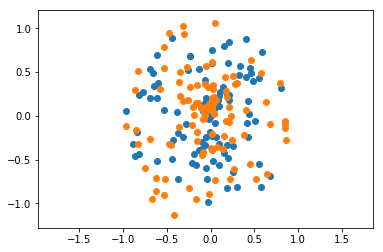

In [15]:
flipstep1 = np.transpose(steps2[0])
flipstep3 = np.transpose(steps2[-1])
plt.scatter(flipstep1[0],flipstep1[1])
plt.scatter(flipstep3[0],flipstep3[1])

plt.axis('equal')

(-1.0663651574529118,
 0.9715639383367515,
 -1.2729988740252245,
 1.2036126243385312)

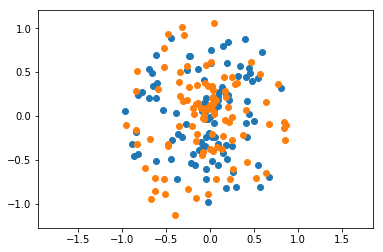

In [16]:
flipstep4 = np.transpose(steps3[0])
flipstep5 = np.transpose(steps3[-1])
plt.scatter(flipstep4[0],flipstep4[1])
plt.scatter(flipstep5[0],flipstep5[1])

plt.axis('equal')

(-1.0665222153567528,
 0.9748621543174114,
 -1.2738282502447442,
 1.2043201621218251)

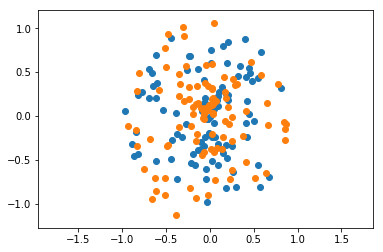

In [17]:
flipstepa = np.transpose(steps4[0])
flipstepb = np.transpose(steps4[-1])
plt.scatter(flipstepa[0],flipstepa[1])
plt.scatter(flipstepb[0],flipstepb[1])

plt.axis('equal')

(-1.066518798686802,
 0.9747904042484473,
 -1.2744815028056113,
 1.204053633433113)

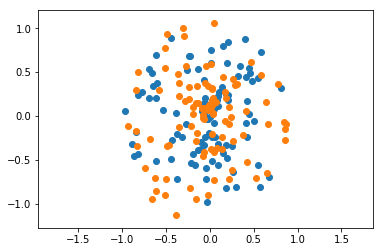

In [18]:
flipstepc = np.transpose(steps5[0])
flipstepd = np.transpose(steps5[-1])
plt.scatter(flipstepc[0],flipstepc[1])
plt.scatter(flipstepd[0],flipstepd[1])

plt.axis('equal')

(-1.0818756945205683,
 0.9704661263957548,
 -1.279105375566838,
 1.2057278579559068)

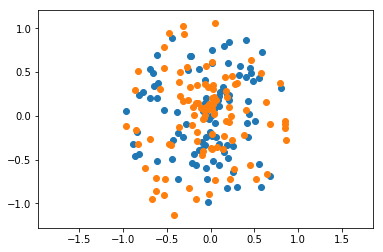

In [19]:
flipstepe = np.transpose(steps6[0])
flipstepf = np.transpose(steps6[-1])
plt.scatter(flipstepe[0],flipstepe[1])
plt.scatter(flipstepf[0],flipstepf[1])

plt.axis('equal')

(-1.0820793978859207,
 0.9763456985388471,
 -1.284125910067609,
 1.2115733036853602)

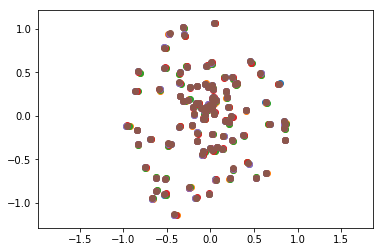

In [20]:
plt.scatter(flipstepf[0],flipstepf[1])
plt.scatter(flipstepd[0],flipstepd[1])
plt.scatter(flipstepb[0],flipstepb[1])
plt.scatter(flipstep5[0],flipstep5[1])
plt.scatter(flipstep3[0],flipstep3[1])
plt.scatter(flipstep2[0],flipstep2[1])

plt.axis('equal')

Qualitatively speaking, these points aren't too different, but let's get quantitative

In [21]:
%%time
quant = particlelist(10, 0.01, 0.001)

Wall time: 0 ns


In [22]:
%%time
theta01 = stepper(100, quant, 0.1, 0.1, 0.3)
theta03 = stepper(100, quant, 0.1, 0.3, 0.3)
theta05 = stepper(100, quant, 0.1, 0.5, 0.3)
theta07 = stepper(100, quant, 0.1, 0.7, 0.3)
theta09 = stepper(100, quant, 0.1, 0.9, 0.3)

Wall time: 4.49 s


In [23]:
def particleL(plist):
    x,y,vx,vy,m = plist
    
    r = np.array([x,y,0])
    v = np.array([vx,vy,0])
    
    L = m * np.cross(r,v)
    
    return(L)

def systemL(particlearray):
    systot = np.zeros(3)
    
    for particle in particlearray:
        L = particleL(particle)
        systot += L
        
    return(systot[2])
    

In [24]:
systemL(quant)

-6.67731717764191e-05

In [25]:
names = [theta01,theta03,theta05,theta07,theta09]

trueL = systemL(quant)

difftheta = []
percerror = []

for i, theta in enumerate(names):
    thetaval = round(i*0.2 + 0.1, 2)
    Lest = systemL(theta[99])
    difference = trueL - Lest
    err = 100 * difference/trueL
    
    difftheta.append([thetaval,difference])
    percerror.append([thetaval,err])

In [26]:
difftheta

[[0.1, 2.4319662569557456e-07],
 [0.3, 2.1966838410167897e-07],
 [0.5, 2.1790553439061011e-07],
 [0.7, 1.2864487461217513e-07],
 [0.9, 1.878094133897642e-07]]

In [27]:
percerror

[[0.1, -0.3642130802321109],
 [0.3, -0.3289770101639154],
 [0.5, -0.32633695329051793],
 [0.7, -0.1926595235627342],
 [0.9, -0.2812647780438205]]

All of these are less than 1% error

In [28]:
%%time
quant2 = particlelist(10, 0.01, 0.001)

t01 = stepper(500, quant2, 0.1, 0.1, 0.3)
t03 = stepper(500, quant2, 0.1, 0.3, 0.3)
t05 = stepper(500, quant2, 0.1, 0.5, 0.3)
t07 = stepper(500, quant2, 0.1, 0.7, 0.3)
t09 = stepper(500, quant2, 0.1, 0.9, 0.3)

Wall time: 12.8 s


In [29]:
names2 = [t01,t03,t05,t07,t09]

trueL2 = systemL(quant2)

difftheta2 = []
percerror2 = []

for i, theta in enumerate(names2):
    thetaval = round(i*0.2 + 0.1, 2)
    Lest = systemL(theta[99])
    difference = trueL2 - Lest
    err = 100 * difference/trueL2
    
    difftheta2.append([thetaval,difference])
    percerror2.append([thetaval,err])

In [30]:
difftheta2

[[0.1, 2.4788361774964106e-07],
 [0.3, 2.695232544658321e-07],
 [0.5, 3.787523836144244e-07],
 [0.7, 6.741438347342848e-08],
 [0.9, 1.9373175128302423e-07]]

In [31]:
percerror2

[[0.1, -0.4115891914335073],
 [0.3, -0.44751992642837696],
 [0.5, -0.6288853968672573],
 [0.7, -0.11193572143537511],
 [0.9, -0.3216747261858645]]

It seems the sweet spot between accuracy and efficiency is around a theta of 0.7

In [32]:
#plt.scatter(flipstep[0],flipstep[1])
#plt.scatter(flipstep2[0],flipstep2[1])

def raddens(stepname,index):
    #input ex: steps6, 0 
    #gives t=0 radial density for steps6 run
    
    array = np.swapaxes(stepname, 1,2)
    xlist = array[index][0]
    ylist = array[index][1]
    
    rlist = []
    
    for i in range(len(xlist)):
        x = xlist[i]
        y = ylist[i]
        r = np.sqrt(x**2 + y**2)
        
        rlist.append(r)
    return(rlist)

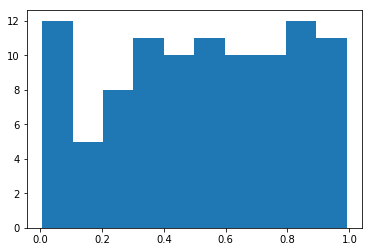

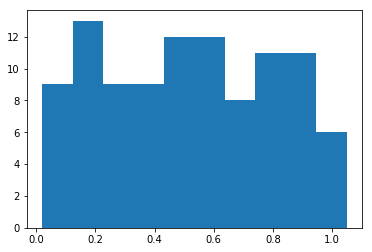

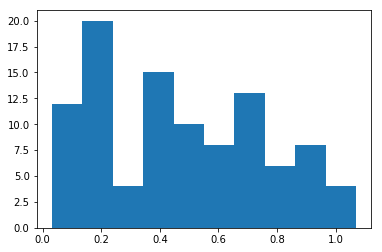

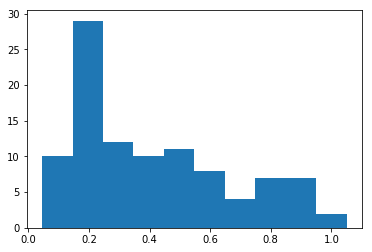

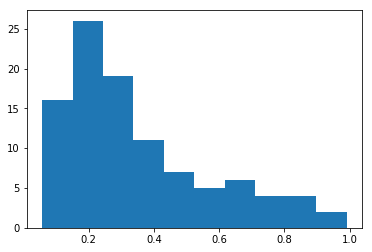

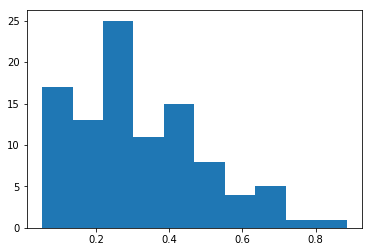

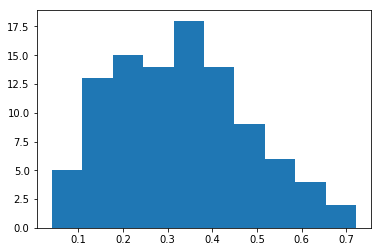

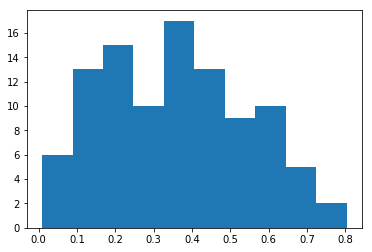

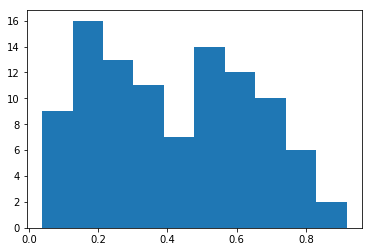

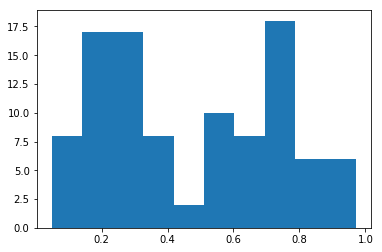

In [33]:
for i in range(10):
    plt.hist(raddens(steps3, i*10))
    plt.show()

Doesn't look like this trial went long enough, to make a core, so let's run a longer one:

In [34]:
%%time
radial1 = particlelist(100, 0.01, 0.001)
longstep = stepper(500, radial1, 0.1, 0.7, 0.3)

Wall time: 2min 11s


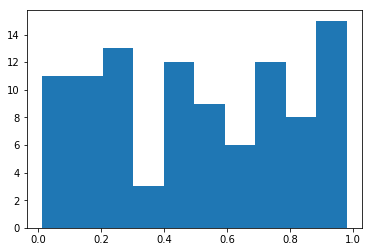

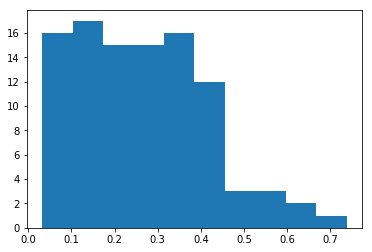

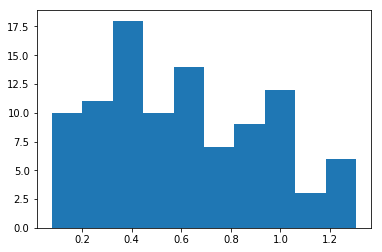

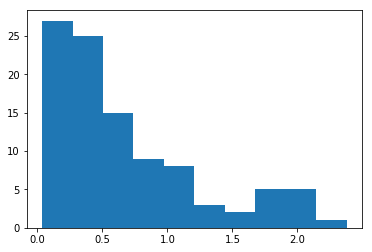

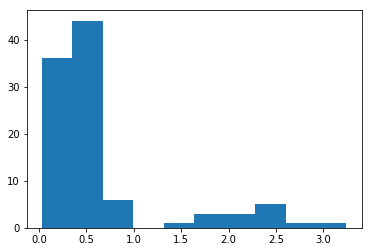

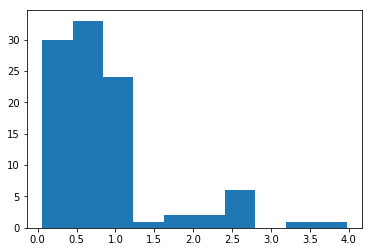

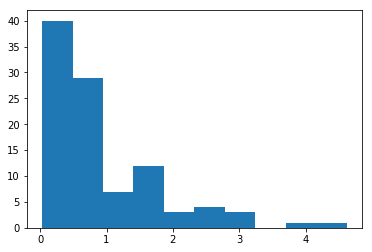

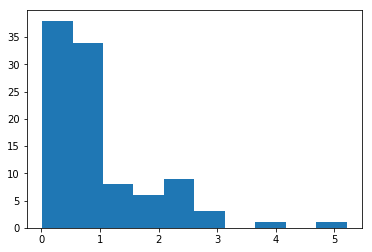

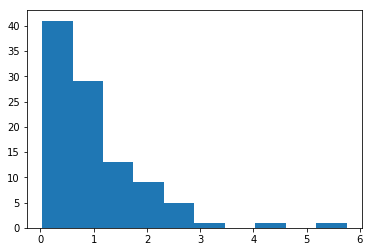

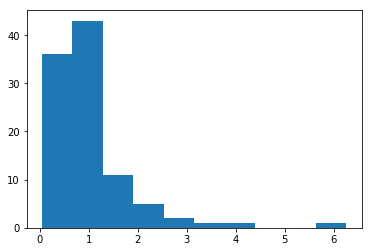

In [35]:
for i in range(10):
    plt.hist(raddens(longstep, i*50))
    plt.show()

This looks like a core to me :)